In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch import nn
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import WeightedRandomSampler
from ignite.metrics import Recall, Precision, Accuracy
from sklearn import metrics
import codecs
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold

In [22]:
torch.cuda.empty_cache()

### Config

In [23]:
conf_dict = {
    "batch_size": 8,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 5,
    "folds": 5,

    "transfer_model_name": "efficientnet-b1",
    "use_backbone": True,

    "input_dir": "../input/seti-breakthrough-listen/",
    "train_dir": "../input/seti-breakthrough-listen/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../input/seti-breakthrough-listen/test/",
    "test_csv": "sample_submission.csv",
    "efficientnetdir": "../input/efficientnetpytorch/",
    "height": 512,
    "width": 512,

    "model": "schnaufnet_trained",
    "model_to_load": "schnaufnet_trained.pth",

    "origin_height": 273,
    "origin_width": 256,

    "only_use": 1000,
    "behaviours": {
        "all": "all",
        "weighted": "weighted",
    },
    "use_all": True,
    "split_until_ratio": (3 / 4),
    "load_model": False,
}
current_split_behaviour = conf_dict["behaviours"]["weighted"]
new_split_behaviour = conf_dict["behaviours"]["all"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [24]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

### Custom Dataset

In [25]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, df, transform=None, use_cv_preprocessing=False):
		self.df = df
		self.labels = self.df["target"].values
		self.file_names = self.df['file_path'].values
		self.transform = transform
		# self.use_cv_preprocessing = use_cv_preprocessing

	def __len__(self):
		return len(self.df)

		# testing with single batch - for example with 1k epochs
		# return conf_dict["batch_size"]

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		# if self.use_cv_preprocessing:
		# 	cadence = Cadence(file_path)
		# 	cadence.cv()

		# image = np.vstack(image).T

		# if self.transform:
		# 	image = self.transform(image=image)['image']
		# else:
		# 	image = image[np.newaxis,:,:] # add dimension
		# 	image = torch.from_numpy(image).float()

		label = torch.tensor(self.labels[idx]).float()

		# image = image.repeat(3, 1, 1) # TODO: probably just repeating the single channel isnt the best way => probably converting grayscale to rgb is better

		return image, label



In [26]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, out_dim, backbone=None, load_schnaufnet_model=False):
        super(EfficientNetBackbone, self).__init__()
        print("Initializing Efficientnet Backbone")
        model_name = conf_dict["transfer_model_name"]
        self.enet = enet.EfficientNet.from_name(model_name)
        if not load_schnaufnet_model:
            print("Loading pretrained efficientnet model")
            pretrained_model = {
                model_name: conf_dict["efficientnetdir"] + 'efficientnet-b1-dbc7070a.pth'
            }
            self.enet.load_state_dict(torch.load(pretrained_model[model_name]))
        else:
            print("Loading pretrained schnaufnet model")
            model.load_state_dict(torch.load(conf_dict["model_to_load"]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [27]:
def split(train_index, val_index, behaviour="all"):
    train_df, val_df = df_train.iloc[train_index], df_train.iloc[val_index]
    
    dataset_train = SETIDataset(train_df, transform=get_transforms(data="train"))#, use_cv_preprocessing_preprocessing=True)
    dataset_val = SETIDataset(val_df, transform=get_transforms(data="val"))#, use_cv_preprocessing=True) # extra dataset für validation, da validation data nicht transformiert werden darf

    if behaviour == conf_dict["behaviours"]["weighted"]:
        print("Using 50/50 weighted data...")
        labels = np.array(dataset_train.labels)
        class_counts = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        num_samples = sum(class_counts)
        class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
        weights = [class_weights[labels[i]] for i in range(int(num_samples))]
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], sampler=sampler)
    elif behaviour == conf_dict["behaviours"]["all"]:
        print("Using original full data...")
        train_dataloader = DataLoader(dataset_train, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    val_dataloader = DataLoader(dataset_val, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    # get_0_1_ratio(train_dataloader, train=True)
    # get_0_1_ratio(val_dataloader, train=True)

    # image, label = next(iter(train_dataloader))
    # print("Shape of image [N, C, H, W]: ", image.shape)
    # print("Shape of label: ", label.shape, label.dtype)

    print(f"Successfully splitted dataset!\n Trainbatches: {len(train_dataloader)}\n Validationbatches: {len(val_dataloader)}")

    return train_dataloader, val_dataloader

def get_0_1_batches_ratio(dataloader):
    print("dataloader length: ", len(dataloader))
    for i, (data, target) in enumerate(dataloader):
        print (f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")

def get_0_1_ratio(dataloader, train):
    dataloader_0 = 0
    dataloader_1 = 0
    for i, (data, target) in enumerate(dataloader):
        dataloader_0 += len(np.where(target.numpy() == 0)[0])
        dataloader_1 += len(np.where(target.numpy() == 1)[0])
    dataloaderinformation = "train" if train else "val"
    print(f"{dataloaderinformation} dataloader 0/1 ratio: {dataloader_0}, {dataloader_1}")

In [28]:
def train_loop(model, train_dataloader, optimizer, loss_fn, scheduler):
    print("Starting model training...")
    model.train()
    epoch_loss = 0
    epoch_loss_list = []
    num_batches = len(train_dataloader)

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    for (images, labels) in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
        epoch_loss_list.append(loss.item())
        epoch_loss += loss.item() # add loss for whole batch
        loss.backward()
        optimizer.step()
        scheduler.step()
        predicted = torch.sigmoid(pred).round() # if precision gets higher => write own function which does not seperate <0.5 and >=0.5 like round currently does
        accuracy.update((predicted, labels))
        precision.update((predicted, labels))
        recall.update((predicted, labels))

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Training Error: \n 
        Accuracy: {100*accuracy.compute():>2f}%, \n
        Recall: {100*recall.compute():>2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """) # avg loss is summed losses for all batches divided with num batches
    # print(f"Epoch loss list: {epoch_loss_list}")
    with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    plt.plot(epoch_loss_list, "ro-")
    plt.title("Loss over epoch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

def validation_loop(model, val_dataloader, loss_fn):
    print("Starting model validation...")
    model.eval()

    epoch_loss = 0
    num_batches = len(val_dataloader)
    epoch_labels = []
    epoch_preds = []

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    with torch.no_grad():
        for (images, labels) in tqdm(val_dataloader, position=0, leave=True, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
            epoch_loss += loss.item()
            predicted = torch.sigmoid(pred).round()
            accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
            predicted = torch.sigmoid(pred)
            labels = labels.detach().cpu().numpy().tolist()
            predicted = predicted.detach().cpu().numpy().tolist()
            epoch_labels.extend(labels)
            epoch_preds.extend(predicted)

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Validation Error: \n
        Accuracy: {100*accuracy.compute():2f}%, \n
        Recall: {100*recall.compute():2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    return epoch_labels, epoch_preds

In [29]:
def get_transforms(data):
    pass
    # if data == 'train':
    #     return A.Compose([
    #         # A.Resize(conf_dict["height"], conf_dict["width"]),
    #         A.VerticalFlip(p=0.5),
    #         A.HorizontalFlip(p=0.5),
    #         ToTensorV2(),
    #     ])
    # elif data == 'val' or data == 'test':
    #     return A.Compose([
    #         # A.Resize(conf_dict["height"], conf_dict["width"]),
    #         ToTensorV2(),
    #     ])

def get_file_path(target, directory):
    return directory + "{}/{}.npy".format(target[0], target)

Initializing Efficientnet Backbone
Loading pretrained efficientnet model
Fold 1/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:42<00:00,  3.06it/s]

Training Error: 
 
        Accuracy: 60.995833%, 

        Recall: 50.164303%, 

        Precision: 64.145524%, 

        Avg loss: 0.635751 

    


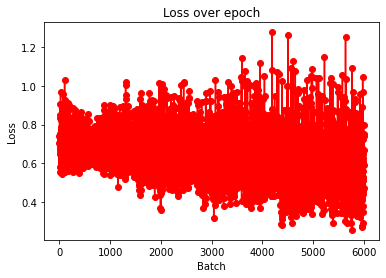

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:00<00:00,  3.56it/s]


Validation Error: 

        Accuracy: 90.108333%, 

        Recall: 36.750000%, 

        Precision: 50.747986%, 

        Avg loss: 0.526299 

    
Val ROC AUC Score: 0.7135380401234568
Fold 1/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [33:06<00:00,  3.02it/s]  

Training Error: 
 
        Accuracy: 69.227083%, 

        Recall: 56.557752%, 

        Precision: 75.817431%, 

        Avg loss: 0.555018 

    


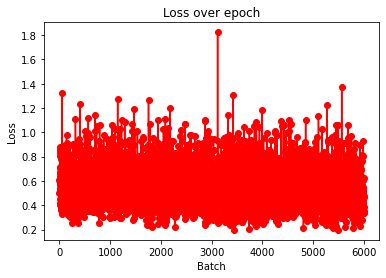

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:29<00:00,  3.34it/s]


Validation Error: 

        Accuracy: 84.458333%, 

        Recall: 48.166667%, 

        Precision: 31.740802%, 

        Avg loss: 0.450846 

    
Val ROC AUC Score: 0.7496046296296296
Fold 1/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:58<00:00,  3.03it/s]


Training Error: 
 
        Accuracy: 71.822917%, 

        Recall: 59.949308%, 

        Precision: 78.781260%, 

        Avg loss: 0.527651 

    


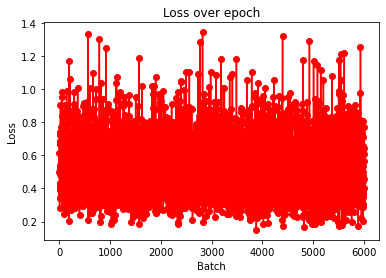

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:57<00:00,  3.60it/s]


Validation Error: 

        Accuracy: 91.083333%, 

        Recall: 40.750000%, 

        Precision: 57.665094%, 

        Avg loss: 0.362130 

    
Val ROC AUC Score: 0.7535178240740741
Fold 1/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [43:25<00:00,  2.30it/s]  

Training Error: 
 
        Accuracy: 92.681250%, 

        Recall: 32.125000%, 

        Precision: 85.809683%, 

        Avg loss: 0.242382 

    


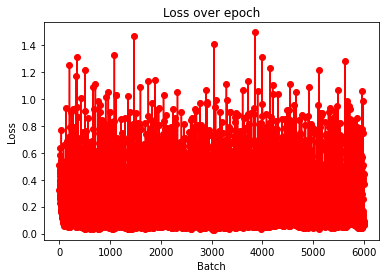

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:18<00:00,  3.42it/s]


Validation Error: 

        Accuracy: 92.616667%, 

        Recall: 28.833333%, 

        Precision: 91.534392%, 

        Avg loss: 0.249572 

    
Val ROC AUC Score: 0.7477148148148147
Fold 1/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:47<00:00,  3.05it/s]

Training Error: 
 
        Accuracy: 73.937500%, 

        Recall: 62.692179%, 

        Precision: 80.738190%, 

        Avg loss: 0.503129 

    


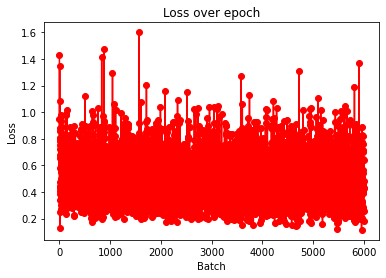

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:00<00:00,  3.56it/s]


Validation Error: 

        Accuracy: 89.283333%, 

        Recall: 41.333333%, 

        Precision: 46.011132%, 

        Avg loss: 0.370186 

    
Val ROC AUC Score: 0.7460581404320987
Fold 2/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [30:19<00:00,  3.30it/s]

Training Error: 
 
        Accuracy: 75.597917%, 

        Recall: 65.548005%, 

        Precision: 82.010223%, 

        Avg loss: 0.483215 

    


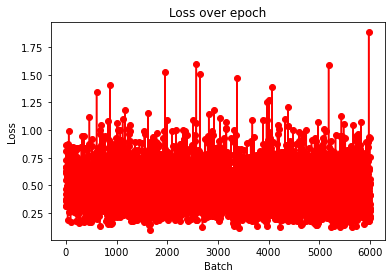

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [15:25<00:00,  1.62it/s]


Validation Error: 

        Accuracy: 85.541667%, 

        Recall: 57.416667%, 

        Precision: 36.016728%, 

        Avg loss: 0.414348 

    
Val ROC AUC Score: 0.8096100308641976
Fold 2/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:37<00:00,  3.06it/s]

Training Error: 
 
        Accuracy: 78.914583%, 

        Recall: 71.512844%, 

        Precision: 83.768684%, 

        Avg loss: 0.444037 

    


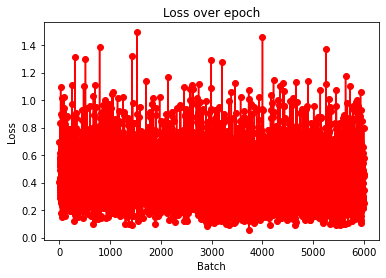

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:05<00:00,  3.53it/s]


Validation Error: 

        Accuracy: 84.741667%, 

        Recall: 56.250000%, 

        Precision: 34.073700%, 

        Avg loss: 0.402924 

    
Val ROC AUC Score: 0.8009160879629631
Fold 2/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:28<00:00,  3.08it/s]


Training Error: 
 
        Accuracy: 80.947917%, 

        Recall: 76.022760%, 

        Precision: 84.443624%, 

        Avg loss: 0.411350 

    


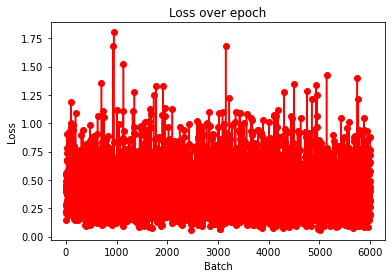

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:10<00:00,  3.48it/s]


Validation Error: 

        Accuracy: 86.175000%, 

        Recall: 53.750000%, 

        Precision: 36.878216%, 

        Avg loss: 0.371087 

    
Val ROC AUC Score: 0.7929257716049383
Fold 2/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [43:15<00:00,  2.31it/s]  

Training Error: 
 
        Accuracy: 93.293750%, 

        Recall: 42.562500%, 

        Precision: 81.556886%, 

        Avg loss: 0.205134 

    


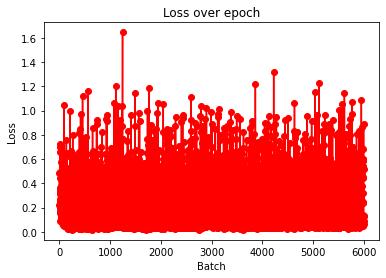

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:49<00:00,  3.66it/s]


Validation Error: 

        Accuracy: 92.391667%, 

        Recall: 41.666667%, 

        Precision: 70.126227%, 

        Avg loss: 0.247972 

    
Val ROC AUC Score: 0.7897301697530864
Fold 2/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [33:09<00:00,  3.02it/s] 

Training Error: 
 
        Accuracy: 83.210417%, 

        Recall: 79.032326%, 

        Precision: 86.041629%, 

        Avg loss: 0.372861 

    


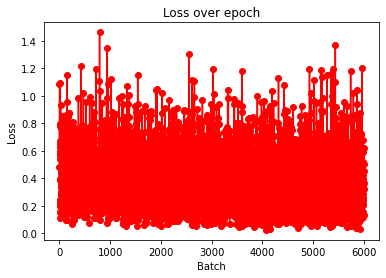

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:07<00:00,  3.51it/s]


Validation Error: 

        Accuracy: 80.083333%, 

        Recall: 58.500000%, 

        Precision: 27.062452%, 

        Avg loss: 0.465999 

    
Val ROC AUC Score: 0.7758936728395062
Fold 3/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [30:36<00:00,  3.27it/s]

Training Error: 
 
        Accuracy: 82.839583%, 

        Recall: 78.188130%, 

        Precision: 86.083993%, 

        Avg loss: 0.385127 

    


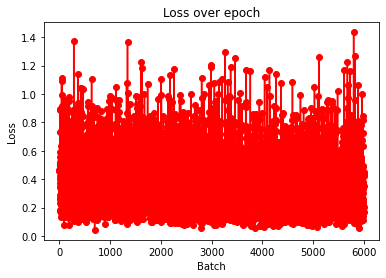

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:00<00:00,  3.57it/s]


Validation Error: 

        Accuracy: 91.375000%, 

        Recall: 61.250000%, 

        Precision: 56.321839%, 

        Avg loss: 0.246288 

    
Val ROC AUC Score: 0.8973642746913579
Fold 3/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:26<00:00,  3.08it/s]

Training Error: 
 
        Accuracy: 85.041667%, 

        Recall: 81.836941%, 

        Precision: 87.143498%, 

        Avg loss: 0.341386 

    


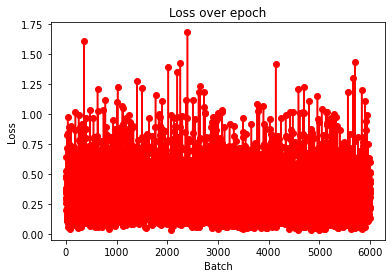

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:46<00:00,  3.69it/s]


Validation Error: 

        Accuracy: 90.116667%, 

        Recall: 62.500000%, 

        Precision: 50.471063%, 

        Avg loss: 0.259738 

    
Val ROC AUC Score: 0.8805086419753088
Fold 3/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:22<00:00,  3.09it/s]

Training Error: 
 
        Accuracy: 87.393750%, 

        Recall: 85.240548%, 

        Precision: 88.961720%, 

        Avg loss: 0.301376 

    


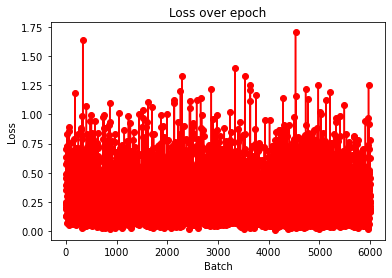

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:58<00:00,  3.59it/s]


Validation Error: 

        Accuracy: 88.941667%, 

        Recall: 59.083333%, 

        Precision: 45.889968%, 

        Avg loss: 0.291301 

    
Val ROC AUC Score: 0.8505354166666665
Fold 3/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [43:08<00:00,  2.32it/s]  

Training Error: 
 
        Accuracy: 93.910417%, 

        Recall: 50.791667%, 

        Precision: 81.293765%, 

        Avg loss: 0.176702 

    


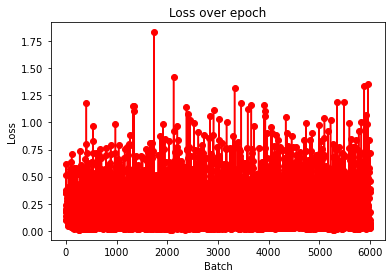

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:47<00:00,  3.68it/s]


Validation Error: 

        Accuracy: 93.283333%, 

        Recall: 42.166667%, 

        Precision: 81.877023%, 

        Avg loss: 0.215699 

    
Val ROC AUC Score: 0.8582798225308642
Fold 3/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [33:05<00:00,  3.02it/s]  

Training Error: 
 
        Accuracy: 88.089583%, 

        Recall: 86.305587%, 

        Precision: 89.534783%, 

        Avg loss: 0.285209 

    


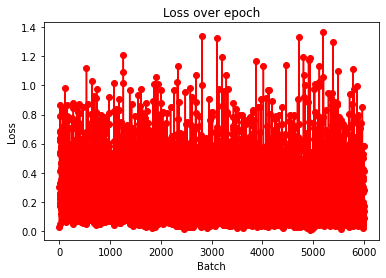

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:03<00:00,  3.54it/s]


Validation Error: 

        Accuracy: 87.258333%, 

        Recall: 61.500000%, 

        Precision: 40.886427%, 

        Avg loss: 0.323592 

    
Val ROC AUC Score: 0.8415751157407408
Fold 4/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [30:47<00:00,  3.25it/s]

Training Error: 
 
        Accuracy: 87.354167%, 

        Recall: 85.662875%, 

        Precision: 88.830266%, 

        Avg loss: 0.301605 

    


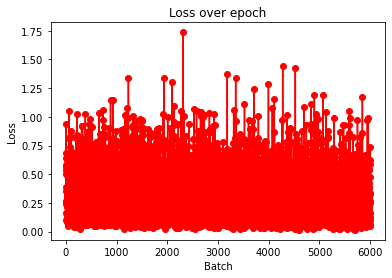

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:01<00:00,  3.56it/s]


Validation Error: 

        Accuracy: 91.641667%, 

        Recall: 79.750000%, 

        Precision: 55.736750%, 

        Avg loss: 0.216260 

    
Val ROC AUC Score: 0.9444539351851852
Fold 4/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:41<00:00,  3.06it/s]

Training Error: 
 
        Accuracy: 89.264583%, 

        Recall: 87.941103%, 

        Precision: 90.310559%, 

        Avg loss: 0.260676 

    


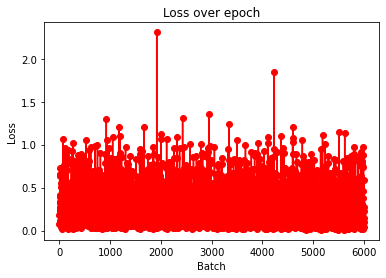

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:53<00:00,  3.63it/s]


Validation Error: 

        Accuracy: 92.716667%, 

        Recall: 65.916667%, 

        Precision: 62.977707%, 

        Avg loss: 0.194559 

    
Val ROC AUC Score: 0.9247046296296297
Fold 4/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [33:05<00:00,  3.02it/s]

Training Error: 
 
        Accuracy: 90.591667%, 

        Recall: 90.049751%, 

        Precision: 91.122672%, 

        Avg loss: 0.234802 

    


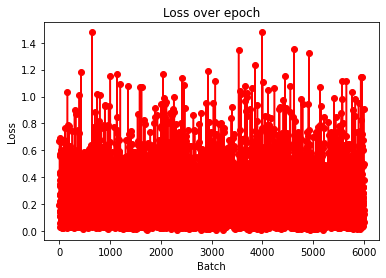

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:01<00:00,  3.55it/s]


Validation Error: 

        Accuracy: 89.675000%, 

        Recall: 70.083333%, 

        Precision: 48.866938%, 

        Avg loss: 0.256204 

    
Val ROC AUC Score: 0.9019509259259259
Fold 4/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [44:13<00:00,  2.26it/s]  

Training Error: 
 
        Accuracy: 94.356250%, 

        Recall: 57.250000%, 

        Precision: 80.704846%, 

        Avg loss: 0.154135 

    


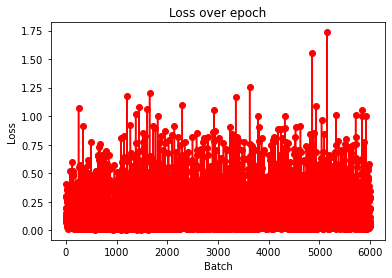

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:53<00:00,  3.63it/s]


Validation Error: 

        Accuracy: 93.266667%, 

        Recall: 46.083333%, 

        Precision: 77.450980%, 

        Avg loss: 0.214496 

    
Val ROC AUC Score: 0.881992862654321
Fold 4/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [33:13<00:00,  3.01it/s] 

Training Error: 
 
        Accuracy: 90.804167%, 

        Recall: 90.021548%, 

        Precision: 91.546566%, 

        Avg loss: 0.228306 

    


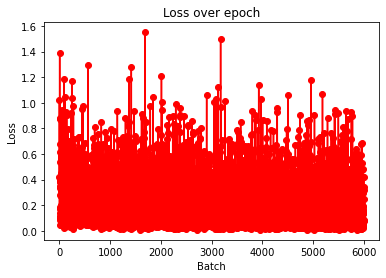

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [07:07<00:00,  3.51it/s]


Validation Error: 

        Accuracy: 90.675000%, 

        Recall: 64.166667%, 

        Precision: 52.775874%, 

        Avg loss: 0.251381 

    
Val ROC AUC Score: 0.8894940586419753
Fold 5/5 | Epoch 1/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [31:25<00:00,  3.18it/s]

Training Error: 
 
        Accuracy: 89.927083%, 

        Recall: 89.029413%, 

        Precision: 90.685651%, 

        Avg loss: 0.251497 

    


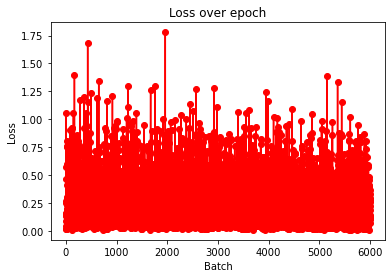

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:48<00:00,  3.67it/s]


Validation Error: 

        Accuracy: 93.325000%, 

        Recall: 82.500000%, 

        Precision: 62.618596%, 

        Avg loss: 0.182607 

    
Val ROC AUC Score: 0.9603686728395062
Fold 5/5 | Epoch 2/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:53<00:00,  3.04it/s]

Training Error: 
 
        Accuracy: 91.570833%, 

        Recall: 90.993724%, 

        Precision: 92.096075%, 

        Avg loss: 0.212201 

    


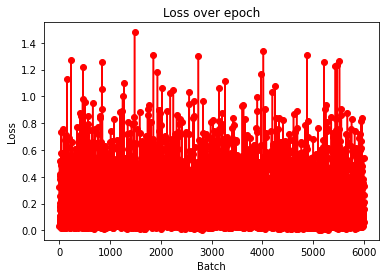

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:41<00:00,  3.74it/s]


Validation Error: 

        Accuracy: 89.508333%, 

        Recall: 81.750000%, 

        Precision: 48.540327%, 

        Avg loss: 0.268246 

    
Val ROC AUC Score: 0.9380848765432099
Fold 5/5 | Epoch 3/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [32:42<00:00,  3.06it/s]

Training Error: 
 
        Accuracy: 92.360417%, 

        Recall: 92.091879%, 

        Precision: 92.582038%, 

        Avg loss: 0.194084 

    


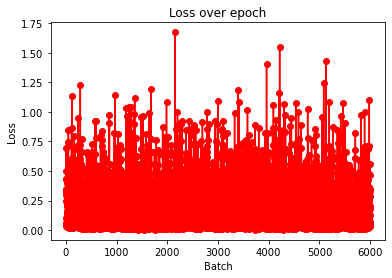

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:47<00:00,  3.68it/s]


Validation Error: 

        Accuracy: 92.783333%, 

        Recall: 64.416667%, 

        Precision: 63.778878%, 

        Avg loss: 0.189945 

    
Val ROC AUC Score: 0.9182875
Fold 5/5 | Epoch 4/5
-------------------------------
Using all behaviour
Using original full data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [43:36<00:00,  2.29it/s]  

Training Error: 
 
        Accuracy: 94.941667%, 

        Recall: 63.208333%, 

        Precision: 82.088745%, 

        Avg loss: 0.137378 

    


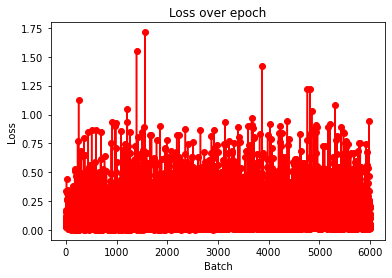

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:35<00:00,  3.79it/s]


Validation Error: 

        Accuracy: 93.808333%, 

        Recall: 46.416667%, 

        Precision: 84.779300%, 

        Avg loss: 0.190841 

    
Val ROC AUC Score: 0.9121353395061728
Fold 5/5 | Epoch 5/5
-------------------------------
Using weighted behaviour
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [33:19<00:00,  3.00it/s]

Training Error: 
 
        Accuracy: 92.389583%, 

        Recall: 91.902800%, 

        Precision: 92.825923%, 

        Avg loss: 0.192361 

    


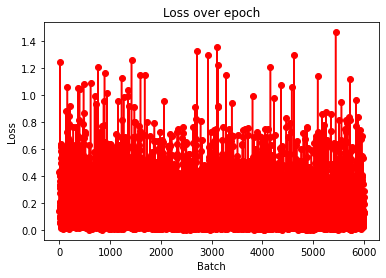

Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [06:54<00:00,  3.62it/s]

Validation Error: 

        Accuracy: 91.633333%, 

        Recall: 64.666667%, 

        Precision: 57.227139%, 

        Avg loss: 0.222177 

    
Val ROC AUC Score: 0.9067280092592593
Training done! Best model in fold 4, epoch 0 with roc_auc of 0.9603686728395062


In [30]:
df_train = pd.read_csv(conf_dict["input_dir"] + conf_dict["train_csv"])
if not conf_dict["use_all"]:
    df_train = df_train[:conf_dict["only_use"]]
df_train["file_path"] = df_train["id"].apply(get_file_path, directory=conf_dict["train_dir"])

loss_fn = nn.BCEWithLogitsLoss() # nn.BCELoss() => needs sigmoid as activation function
num_epochs = conf_dict["epochs"]
num_folds = conf_dict["folds"]
skf = StratifiedKFold(n_splits=num_folds)

with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
    up.write("------------------ new training ------------------")
with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
    up.write("------------------ new validation ------------------")

model = EfficientNetBackbone(out_dim=1, load_schnaufnet_model=conf_dict["load_model"])
model.to(device)

for fold, (train_index, val_index) in enumerate(skf.split(df_train, df_train["target"])):
    optimizer = torch.optim.Adam(model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"]) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
    )
    best_roc_auc = 0
    best_roc_auc_fold = 0
    best_roc_auc_fold_epoch = 0
    for epoch in range(num_epochs):
        print(f"Fold {fold + 1}/{num_folds} | Epoch {epoch + 1}/{num_epochs}\n-------------------------------")
        if epoch == math.floor(num_epochs * conf_dict["split_until_ratio"]):
            print(f"Using {new_split_behaviour} behaviour")
            train_dataloader, val_dataloader = split(train_index, val_index, behaviour=new_split_behaviour)
        else:
            print(f"Using {current_split_behaviour} behaviour")
            train_dataloader, val_dataloader = split(train_index, val_index, behaviour=current_split_behaviour)
        train_loop(model, train_dataloader, optimizer, loss_fn, scheduler)
        val_labels, val_predictions = validation_loop(model, val_dataloader, loss_fn)
        roc_auc = metrics.roc_auc_score(val_labels, val_predictions)
        print(f"Val ROC AUC Score: {roc_auc}")
        with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
            up.write(f"""
                Epoch={epoch}, Valid ROC AUC={roc_auc}\n
            """)
        if roc_auc > best_roc_auc:
            torch.save(model.state_dict(), "best_roc_auc_" + conf_dict["model"] + "-" + str(fold) + "-" + str(epoch) + ".pth")
            best_roc_auc = roc_auc
            best_roc_auc_fold = fold
            best_roc_auc_epoch = epoch
    # torch.save(model.state_dict(), "version_" + conf_dict["model"] + "-" + str(fold) + ".pth")
print(f"Training done! Best model in fold {best_roc_auc_fold}, epoch {best_roc_auc_epoch} with roc_auc of {best_roc_auc}")
